## Imports 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, r2_score, explained_variance_score, roc_auc_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelBinarizer
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.linear_model import Lasso

import torch
from torch import nn
import torch.nn.functional as F

from dp_wgan import Generator, Discriminator
from dp_autoencoder import Autoencoder
from evaluation import *
import dp_optimizer, sampling, analysis, evaluation

torch.manual_seed(0)
np.random.seed(0)

## Setup 

In [8]:
print(f"GPU is available: {torch.cuda.is_available()}")

GPU is available: True


## Load data 

In [2]:
names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'salary']
train = pd.read_csv('adult.data', names=names)
test = pd.read_csv('adult.test', names=names)

df = pd.concat([train, test])

df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16276,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,<=50K
16277,64,?,321403,HS-grad,9,Widowed,?,Other-relative,Black,Male,0,0,40,United-States,<=50K
16278,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,<=50K
16279,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,<=50K


## Preprocess and split data 

### Preprocessing depending on data type 

In [3]:
class Processor:
    def __init__(self, datatypes):
        self.datatypes = datatypes
        
    def fit(self, matrix):
        preprocessors, cutoffs = [], []
        for i, (column, datatype) in enumerate(self.datatypes):
            preprocessed_col = matrix[:,i].reshape(-1, 1)

            if 'categorical' in datatype:
                preprocessor = LabelBinarizer()
            else:
                preprocessor = MinMaxScaler()

            preprocessed_col = preprocessor.fit_transform(preprocessed_col)
            cutoffs.append(preprocessed_col.shape[1])
            preprocessors.append(preprocessor)
        
        self.cutoffs = cutoffs
        self.preprocessors = preprocessors
    
    def transform(self, matrix):
        preprocessed_cols = []
        
        for i, (column, datatype) in enumerate(self.datatypes):
            preprocessed_col = matrix[:,i].reshape(-1, 1)
            preprocessed_col = self.preprocessors[i].transform(preprocessed_col)
            preprocessed_cols.append(preprocessed_col)

        return np.concatenate(preprocessed_cols, axis=1)

        
    def fit_transform(self, matrix):
        self.fit(matrix)
        return self.transform(matrix)
            
    def inverse_transform(self, matrix):
        postprocessed_cols = []

        j = 0
        for i, (column, datatype) in enumerate(self.datatypes):
            postprocessed_col = self.preprocessors[i].inverse_transform(matrix[:,j:j+self.cutoffs[i]])

            if 'categorical' in datatype:
                postprocessed_col = postprocessed_col.reshape(-1, 1)
            else:
                if 'positive' in datatype:
                    postprocessed_col = postprocessed_col.clip(min=0)

                if 'int' in datatype:
                    postprocessed_col = postprocessed_col.round()

            postprocessed_cols.append(postprocessed_col)
            
            j += self.cutoffs[i]
        
        return np.concatenate(postprocessed_cols, axis=1)


datatypes = [
    ('age', 'positive int'),
    ('workclass', 'categorical'),
    ('education-num', 'categorical'),
    ('marital-status', 'categorical'),
    ('occupation', 'categorical'),
    ('relationship', 'categorical'),
    ('race', 'categorical'),
    ('sex', 'categorical binary'),
    ('capital-gain', 'positive float'),
    ('capital-loss', 'positive float'),
    ('hours-per-week', 'positive int'),
    ('native-country', 'categorical'),
    ('salary', 'categorical binary'),
]

### Split preprocessed data 

In [4]:
processor = Processor(datatypes)

relevant_df = df.drop(columns=['education', 'fnlwgt'])
for column, datatype in datatypes:
    if 'categorical' in datatype:
        relevant_df[column] = relevant_df[column].astype('category').cat.codes
        
train_df = relevant_df.head(32562)

X_real = torch.tensor(relevant_df.values.astype('float32'))
X_encoded = torch.tensor(processor.fit_transform(X_real).astype('float32'))

train_cutoff = 32562  # 2/3 of the whole data

X_train_real = X_real[:train_cutoff]
X_test_real = X_real[:train_cutoff]

X_train_encoded = X_encoded[:train_cutoff]
X_test_encoded = X_encoded[train_cutoff:]

print(f"Shape of entire dataset: {X_encoded.shape}")
print()
print("X train preview")
print(X_train_encoded)
print()
print("X test preview")
print(X_test_encoded)

Shape of entire dataset: torch.Size([48842, 106])

X train preview
tensor([[0.3014, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.4521, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2877, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0685, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.4795, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.0000],
        [0.1096, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])

X test preview
tensor([[0.2877, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.1507, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.0000],
        [0.3699, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.2877, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.3699, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2466, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.0000]])


In [5]:
# Check if there's missing values
def isnan(x):
    return x != x
print(f"Any missing values? {isnan(X_encoded).any().item()}")

Any missing values? False


## Train AutoEncoder 

In [6]:
ae_params = {
    'b1': 0.9,
    'b2': 0.999,
    'binary': False,
    'compress_dim': 15,
    'delta': 1e-5,
    'device': 'cuda',
    'iterations': 20000,  # Set to 20000 in their code
    'lr': 0.005,
    'l2_penalty': 0.,
    'l2_norm_clip': 0.012,
    'minibatch_size': 64,
    'microbatch_size': 1,
    'noise_multiplier': 2.5,
    'nonprivate': True,
}

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=106, out_features=60, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=60, out_features=15, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
  )
  (decoder): Sequential(
    (0): Linear(in_features=15, out_features=60, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=60, out_features=106, bias=True)
    (3): Sigmoid()
  )
)
Achieves (0.5664574123252802, 1e-05)-DP
[Iteration 2000/20000] [Loss: 0.059386] [Validation Loss: 0.061102]
[Iteration 4000/20000] [Loss: 0.041160] [Validation Loss: 0.038103]
[Iteration 6000/20000] [Loss: 0.032250] [Validation Loss: 0.031604]
[Iteration 8000/20000] [Loss: 0.031379] [Validation Loss: 0.027945]
[Iteration 10000/20000] [Loss: 0.021503] [Validation Loss: 0.026047]
[Iteration 12000/20000] [Loss: 0.018871] [Validation Loss: 0.024144]
[Iteration 14000/20000] [Loss: 0.023389] [Validation Loss: 0.022900]
[Iteration 16000/20000] [Loss:

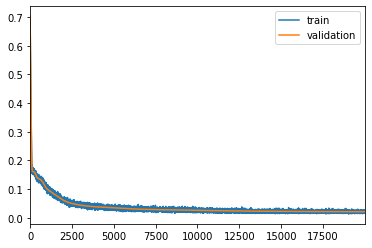

In [7]:
autoencoder = Autoencoder(
    example_dim=len(X_train_encoded[0]),
    compression_dim=ae_params['compress_dim'],
    binary=ae_params['binary'],
    device=ae_params['device'],
)

decoder_optimizer = dp_optimizer.DPAdam(
    l2_norm_clip=ae_params['l2_norm_clip'],
    noise_multiplier=ae_params['noise_multiplier'],
    minibatch_size=ae_params['minibatch_size'],
    microbatch_size=ae_params['microbatch_size'],
    nonprivate=ae_params['nonprivate'],
    params=autoencoder.get_decoder().parameters(),
    lr=ae_params['lr'],
    betas=(ae_params['b1'], ae_params['b2']),
    weight_decay=ae_params['l2_penalty'],
)

encoder_optimizer = torch.optim.Adam(
    params=autoencoder.get_encoder().parameters(),
    lr=ae_params['lr'] * ae_params['microbatch_size'] / ae_params['minibatch_size'],
    betas=(ae_params['b1'], ae_params['b2']),
    weight_decay=ae_params['l2_penalty'],
)

weights, ds = [], []
for name, datatype in datatypes:
    if 'categorical' in datatype:
        num_values = len(np.unique(relevant_df[name]))
        if num_values == 2:
            weights.append(1.)
            ds.append((datatype, 1))
        else:
            for i in range(num_values):
                weights.append(1. / num_values)
            ds.append((datatype, num_values))
    else:
        weights.append(1.)
        ds.append((datatype, 1))
weights = torch.tensor(weights).to(ae_params['device'])

#autoencoder_loss = (lambda input, target: torch.mul(weights, torch.pow(input-target, 2)).sum(dim=1).mean(dim=0))
#autoencoder_loss = lambda input, target: torch.mul(weights, F.binary_cross_entropy(input, target, reduction='none')).sum(dim=1).mean(dim=0)
autoencoder_loss = nn.BCELoss()
#autoencoder_loss = nn.MSELoss()

print(autoencoder)

print('Achieves ({}, {})-DP'.format(
    analysis.epsilon(
        len(X_train_encoded),
        ae_params['minibatch_size'],
        ae_params['noise_multiplier'],
        ae_params['iterations'],
        ae_params['delta']
    ),
    ae_params['delta'],
))

minibatch_loader, microbatch_loader = sampling.get_data_loaders(
    minibatch_size=ae_params['minibatch_size'],
    microbatch_size=ae_params['microbatch_size'],
    iterations=ae_params['iterations'],
    nonprivate=ae_params['nonprivate'],
)

train_losses, validation_losses = [], []

X_train_encoded = X_train_encoded.to(ae_params['device'])
X_test_encoded = X_test_encoded.to(ae_params['device'])

for iteration, X_minibatch in enumerate(minibatch_loader(X_train_encoded)):
    
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    for X_microbatch in microbatch_loader(X_minibatch):

        decoder_optimizer.zero_microbatch_grad()
        output = autoencoder(X_microbatch)
        loss = autoencoder_loss(output, X_microbatch)
        loss.backward()
        decoder_optimizer.microbatch_step()
        
    validation_loss = autoencoder_loss(autoencoder(X_test_encoded).detach(), X_test_encoded)
    
    encoder_optimizer.step()
    decoder_optimizer.step()

    train_losses.append(loss.item())
    validation_losses.append(validation_loss.item())

    if (iteration + 1) % (ae_params["iterations"] // 10) == 0:
        print ('[Iteration %d/%d] [Loss: %f] [Validation Loss: %f]' % (
            iteration + 1, ae_params['iterations'], loss.item(), validation_loss.item())
        )

pd.DataFrame(data={'train': train_losses, 'validation': validation_losses}).plot()

In [9]:
# Save autoencoder model
with open('ae_eps_inf.dat', 'wb') as f:
    torch.save(autoencoder, f)

## Train GAN 

In [10]:
gan_params = {
    'alpha': 0.99,
    'binary': False,
    'clip_value': 0.01,
    'd_updates': 15,
    'delta': 1e-5,
    'device': 'cuda',
    'iterations': 15000,  # Set to 15000 in their code
    'latent_dim': 64,
    'lr': 0.005,
    'l2_penalty': 0.,
    'l2_norm_clip': 0.022,
    'minibatch_size': 128,
    'microbatch_size': 1,
    'noise_multiplier': 3.5,
    'nonprivate': False,
}

Generator(
  (block_0): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=False)
    (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (block_1): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=False)
    (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (block_2): Sequential(
    (0): Linear(in_features=64, out_features=15, bias=False)
    (1): LayerNorm((15,), eps=1e-05, elementwise_affine=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
)
Discriminator(
  (model): Sequential(
    (0): Linear(in_features=106, out_features=70, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=70, out_features=35, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=35, out_features=1, bias=True)
  )
)
Achieves (0.687574376936809, 1e-05)-DP
[Iteration 1500/15000] [D loss: -0.000015] [G loss: -0.001485]


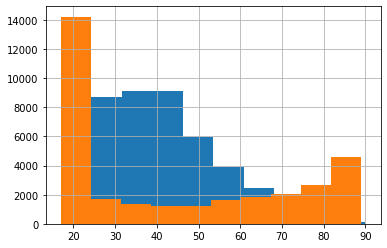

[Iteration 3000/15000] [D loss: 0.000014] [G loss: -0.009934]


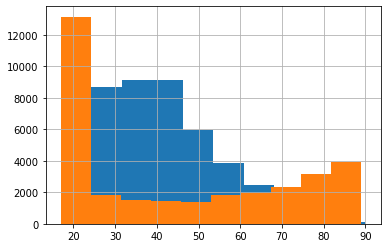

[Iteration 4500/15000] [D loss: -0.000055] [G loss: -0.009173]


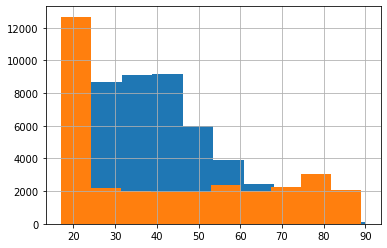

[Iteration 6000/15000] [D loss: -0.000032] [G loss: 0.001751]


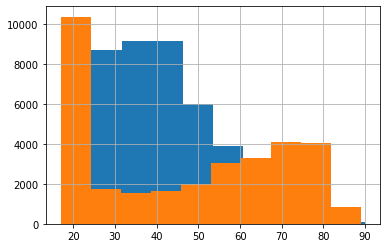

[Iteration 7500/15000] [D loss: -0.000001] [G loss: 0.004372]


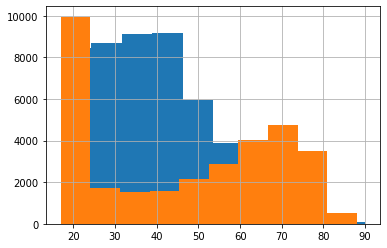

[Iteration 9000/15000] [D loss: 0.000021] [G loss: -0.001292]


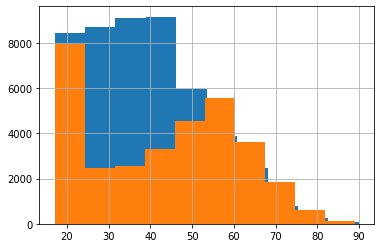

[Iteration 10500/15000] [D loss: 0.000010] [G loss: -0.010249]


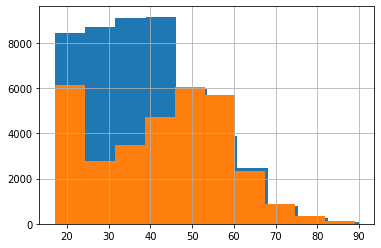

[Iteration 12000/15000] [D loss: -0.000054] [G loss: -0.009911]


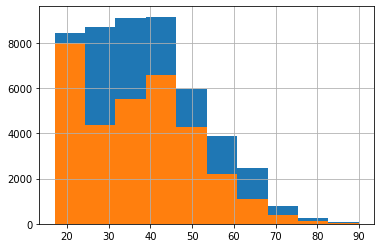

[Iteration 13500/15000] [D loss: -0.000024] [G loss: -0.000159]


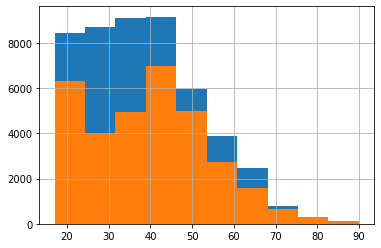

[Iteration 15000/15000] [D loss: 0.000009] [G loss: 0.000563]


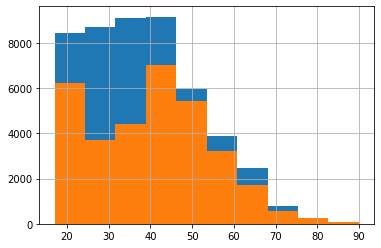

In [11]:
with open('ae_eps_inf.dat', 'rb') as f:
    autoencoder = torch.load(f)
decoder = autoencoder.get_decoder()
    
generator = Generator(
    input_dim=gan_params['latent_dim'],
    output_dim=autoencoder.get_compression_dim(),
    binary=gan_params['binary'],
    device=gan_params['device'],
)

g_optimizer = torch.optim.RMSprop(
    params=generator.parameters(),
    lr=gan_params['lr'],
    alpha=gan_params['alpha'],
    weight_decay=gan_params['l2_penalty'],
)

discriminator = Discriminator(
    input_dim=len(X_train_encoded[0]),
    device=gan_params['device'],
)

d_optimizer = dp_optimizer.DPRMSprop(
    l2_norm_clip=gan_params['l2_norm_clip'],
    noise_multiplier=gan_params['noise_multiplier'],
    minibatch_size=gan_params['minibatch_size'],
    microbatch_size=gan_params['microbatch_size'],
    nonprivate=gan_params['nonprivate'],
    params=discriminator.parameters(),
    lr=gan_params['lr'],
    alpha=gan_params['alpha'],
    weight_decay=gan_params['l2_penalty'],
)

print(generator)
print(discriminator)

print('Achieves ({}, {})-DP'.format(
    analysis.epsilon(
        len(X_train_encoded),
        gan_params['minibatch_size'],
        gan_params['noise_multiplier'],
        gan_params['iterations'],
        gan_params['delta']
    ),
    gan_params['delta'],
))

minibatch_loader, microbatch_loader = sampling.get_data_loaders(
    minibatch_size=gan_params['minibatch_size'],
    microbatch_size=gan_params['microbatch_size'],
    iterations=gan_params['iterations'],
    nonprivate=gan_params['nonprivate'],
)

X_train_encoded = X_train_encoded.to(gan_params['device'])
X_test_encoded = X_test_encoded.to(ae_params['device'])

for iteration, X_minibatch in enumerate(minibatch_loader(X_train_encoded)):
    
    d_optimizer.zero_grad()
    
    for real in microbatch_loader(X_minibatch):
        z = torch.randn(real.size(0), gan_params['latent_dim'], device=gan_params['device'])
        fake = decoder(generator(z)).detach()
        
        d_optimizer.zero_microbatch_grad()
        d_loss = -torch.mean(discriminator(real)) + torch.mean(discriminator(fake))
        d_loss.backward()
        d_optimizer.microbatch_step()
    
    d_optimizer.step()

    for parameter in discriminator.parameters():
        parameter.data.clamp_(-gan_params['clip_value'], gan_params['clip_value'])

    if iteration % gan_params['d_updates'] == 0:
        z = torch.randn(X_minibatch.size(0), gan_params['latent_dim'], device=gan_params['device'])
        fake = decoder(generator(z))

        g_optimizer.zero_grad()
        g_loss = -torch.mean(discriminator(fake))
        g_loss.backward()
        g_optimizer.step()

    if (iteration + 1) % (gan_params["iterations"] // 10) == 0:
        print('[Iteration %d/%d] [D loss: %f] [G loss: %f]' % (
            iteration + 1, gan_params['iterations'], d_loss.item(), g_loss.item()
        ))
        
        z = torch.randn(len(X_train_real), gan_params['latent_dim'], device=gan_params['device'])
        X_synthetic_encoded = decoder(generator(z)).cpu().detach().numpy()
        X_synthetic_real = processor.inverse_transform(X_synthetic_encoded)
        X_synthetic_encoded = processor.transform(X_synthetic_real)
        synthetic_data = pd.DataFrame(X_synthetic_real, columns=relevant_df.columns)

        i = 0
        columns = relevant_df.columns
        relevant_df[columns[i]].hist()
        synthetic_data[columns[i]].hist()
        plt.show()
                
        #pca_evaluation(pd.DataFrame(X_train_real), pd.DataFrame(X_synthetic_real))
        #plt.show()


In [12]:
# Save generator model
with open('gen_eps_inf.dat', 'wb') as f:
    torch.save(generator, f)

### Check RF classifier test accuracy on "salary" target

In [13]:
X_train_encoded = X_train_encoded.cpu()
X_test_encoded = X_test_encoded.cpu()

clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train_encoded[:,:-1], X_train_encoded[:,-1])
prediction = clf.predict(X_test_encoded[:,:-1])

print(f"Accuracy: {accuracy_score(X_test_encoded[:,-1], prediction)}")
print(f"F1-score: {f1_score(X_test_encoded[:,-1], prediction)}")

Accuracy: 0.8442874692874693
F1-score: 0.6487460163502842


## Synthetic data 

### Generation 

In [14]:
with open('gen_eps_inf.dat', 'rb') as f:
    generator = torch.load(f)
    
with open('ae_eps_inf.dat', 'rb') as f:
    autoencoder = torch.load(f)
decoder = autoencoder.get_decoder()

z = torch.randn(len(X_train_real), gan_params['latent_dim'], device=gan_params['device'])
X_synthetic_encoded = decoder(generator(z)).cpu().detach().numpy()
X_synthetic_real = processor.inverse_transform(X_synthetic_encoded)
X_synthetic_encoded = processor.transform(X_synthetic_real)

#pd.DataFrame(X_encoded.numpy()).to_csv('real.csv')
pd.DataFrame(X_synthetic_encoded).to_csv('synthetic.csv')

### Check RF classifier accuracy on test_real when fitted on synthetic

In [15]:
with open('gen_eps_inf.dat', 'rb') as f:
    generator = torch.load(f)
    
with open('ae_eps_inf.dat', 'rb') as f:
    autoencoder = torch.load(f)
decoder = autoencoder.get_decoder()
    
X_test_encoded = X_test_encoded.cpu()

z = torch.randn(len(X_train_real), gan_params['latent_dim'], device=gan_params['device'])
X_synthetic_encoded = decoder(generator(z)).cpu().detach().numpy()

X_synthetic_real = processor.inverse_transform(X_synthetic_encoded)
X_synthetic_encoded = processor.transform(X_synthetic_real)

clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_synthetic_encoded[:,:-1], X_synthetic_encoded[:,-1])
prediction = clf.predict(X_test_encoded[:,:-1])

print(f"Accuracy: {accuracy_score(X_test_encoded[:,-1], prediction)}")
print(f"F1-score: {f1_score(X_test_encoded[:,-1], prediction)}")

Accuracy: 0.7906633906633906
F1-score: 0.33748055987558323


### Histogram of "Age" distribution in synthetic vs real

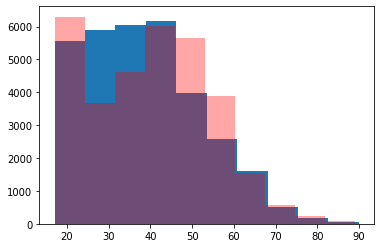

In [22]:
with open('gen_eps_inf.dat', 'rb') as f:
    generator = torch.load(f)
    
with open('ae_eps_inf.dat', 'rb') as f:
    autoencoder = torch.load(f)
decoder = autoencoder.get_decoder()

z = torch.randn(len(X_train_real), gan_params['latent_dim'], device=gan_params['device'])
X_synthetic_encoded = decoder(generator(z)).cpu().detach().numpy()
X_synthetic_real = processor.inverse_transform(X_synthetic_encoded)
synthetic_data = pd.DataFrame(X_synthetic_real, columns=relevant_df.columns)

column = 'age'
fig = plt.figure()
ax = fig.add_subplot()
ax.hist(train_df[column].values,)# bins=)
ax.hist(synthetic_data[column].values, color='red', alpha=0.35,)# bins10)
plt.show()

### Dimension-wise prediction scatterplot

age positive int
r2_score
Real: 0.2818276514546748
Synthetic: 0.2786631546336934

workclass categorical
f1_score
Real: 0.7128378378378378
Synthetic: 0.6600737100737101

education-num categorical
f1_score
Real: 0.3343980343980344
Synthetic: 0.2715601965601966

marital-status categorical
f1_score
Real: 0.8164619164619163
Synthetic: 0.7409705159705159

occupation categorical
f1_score
Real: 0.31769041769041767
Synthetic: 0.1340909090909091

relationship categorical
f1_score
Real: 0.7598280098280098
Synthetic: 0.5329238329238329

race categorical
f1_score
Real: 0.8405405405405405
Synthetic: 0.7537469287469287

sex categorical binary
f1_score
Real: 0.8675149700598803
Synthetic: 0.7299452188533927

capital-gain positive float
r2_score
Real: 0.0842600819364091
Synthetic: -1.0244584738125297

capital-loss positive float
r2_score
Real: 0.025128599655994677
Synthetic: -0.11394951754211347

hours-per-week positive int
r2_score
Real: 0.03869403234808988
Synthetic: -0.04880653800769119

native-count

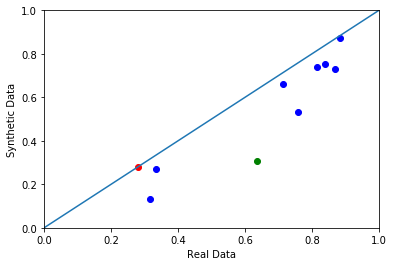

In [24]:
with open('gen_eps_inf.dat', 'rb') as f:
    generator = torch.load(f)
    
with open('ae_eps_inf.dat', 'rb') as f:
    autoencoder = torch.load(f)
decoder = autoencoder.get_decoder()

z = torch.randn(len(X_train_real), gan_params['latent_dim'], device=gan_params['device'])
X_synthetic_encoded = decoder(generator(z)).cpu().detach().numpy()
X_synthetic_real = processor.inverse_transform(X_synthetic_encoded)
synthetic_data = pd.DataFrame(X_synthetic_real, columns=relevant_df.columns)

regression_real = []
classification_real = []
regression_synthetic = []
classification_synthetic = []
target_real = []
target_synthetic = []

for column, datatype in datatypes:
    p = Processor([datatype for datatype in datatypes if datatype[0] != column])
    
    train_cutoff = 32562
    
    p.fit(relevant_df.drop(columns=[column]).values)

    X_enc = p.transform(relevant_df.drop(columns=[column]).values)
    y_enc = relevant_df[column]

    X_enc_train = X_enc[:train_cutoff]
    X_enc_test = X_enc[train_cutoff:]
    
    y_enc_train = y_enc[:train_cutoff]
    y_enc_test = y_enc[train_cutoff:]

    X_enc_syn = p.transform(synthetic_data.drop(columns=[column]).values)
    y_enc_syn = synthetic_data[column]
        
    if 'binary' in datatype:
        model = lambda: RandomForestClassifier(n_estimators=10)
        score = lambda true, pred: f1_score(true, pred)
        score.__name__ = "f1_score"
    elif 'categorical' in datatype:
        model = lambda: RandomForestClassifier(n_estimators=10)
        score = lambda true, pred: f1_score(true, pred, average='micro')
        score.__name__ = "f1_score"
    else:
        model = lambda: Lasso()
        explained_var = lambda true, pred: explained_variance_score(true, pred)
        score = r2_score
     
    real, synthetic = model(), model()
    
    real.fit(X_enc_train, y_enc_train)
    synthetic.fit(X_enc_syn, y_enc_syn)
    
    real_preds = real.predict(X_enc_test)
    synthetic_preds = synthetic.predict(X_enc_test)
    
    print(column, datatype)
    if column == 'salary':
        target_real.append(score(y_enc_test, real_preds))
        target_synthetic.append(score(y_enc_test, synthetic_preds))
    elif 'categorical' in datatype:
        classification_real.append(score(y_enc_test, real_preds))
        classification_synthetic.append(score(y_enc_test, synthetic_preds))
    else:
        regression_real.append(score(y_enc_test, real_preds))
        regression_synthetic.append(score(y_enc_test, synthetic_preds))
    
    print(score.__name__)
    print('Real: {}'.format(score(y_enc_test, real_preds)))
    print('Synthetic: {}'.format(score(y_enc_test, synthetic_preds)))
    print('')
    
plt.scatter(classification_real, classification_synthetic, c='blue')
plt.scatter(regression_real, regression_synthetic, c='red')
plt.scatter(target_real, target_synthetic, c='green')
plt.xlabel('Real Data')
plt.ylabel('Synthetic Data')
plt.axis((0., 1., 0., 1.))
plt.plot((0, 1), (0, 1))
plt.show()